/home/qhy/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


本算法需谨慎使用先验知识，有可能会导致结果比先验知识差。


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


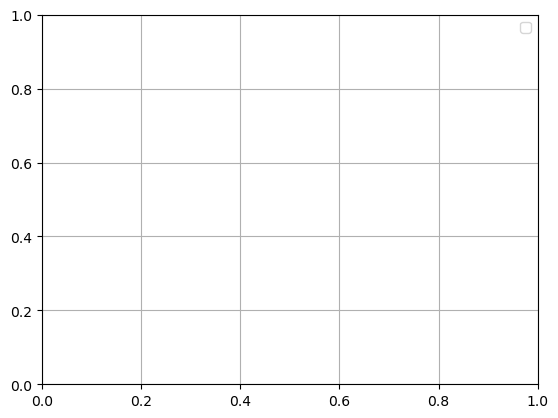

Execution time: 8.007077693939209 s
Evaluation number: 45500
The number of non-dominated solutions is: 15
hv: 1.39378
spacing: 13.43536


In [1]:
import numpy as np
import geatpy as ea
import torch 
import sys
sys.path.append("..")
from predictor.mlp import FeedforwardNet
sys.path.append("../encode+decode/")
from decode import decode,decode_lite
from flops_params import flops_params
def init_pop(acc=91):
    data= np.load("/home/qhy/Reserach/AICAS/predictor/dataset/data-dict-980.npy",allow_pickle=True).item()
    pop_init = []
    num = []
    for k in data.keys():
        if data[k]['acc'] > acc:
            pop_init.append(np.array(data[k]['code'])*np.array([8]*5+[1]*16))
            num.append(k)
    return pop_init,len(num)


model_path = "/home/qhy/Reserach/AICAS/predictor/MLP/loss-mse-input_dims-21-num_layers-4-layer_width-40_30_20_10-lr-0.1-regular-0.1-r-train-0.9238-r-test-0.9443.pth"
model_param = torch.load(model_path)
hyperparams = model_param["hyperparams"]
predictor = FeedforwardNet(hyperparams["input_dims"],hyperparams["num_layers"],hyperparams["layer_width"],1,'relu')
predictor.load_state_dict(model_param['model'])

class EA_S(ea.Problem):  # 继承Problem父类
    def __init__(self,model):
        name = 'EA'  # 初始化name（函数名称，可以随意设置）
        M = 1  # 优化目标个数
        maxormins = [1] *M  # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = M  # 初始化Dim（决策变量维数）
        varTypes = [1] * 21  # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [1]*5+[0]*5+[0]*6+[1]*5  # 决策变量下界
        ub = [8]*5+[1]*5+[2]*6+[2,4,6,8,4]  # 决策变量上界
        lbin = [1]*21  # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1]*21  # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        self.predictor = model
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)

    def aimFunc(self, pop):  # 目标函数
        Vars = pop.Phen  # 获取决策变量矩阵，它等于种群的表现型矩阵Phen
        Vars = torch.tensor(np.array(Vars,dtype=np.float32))
        accuracy = []
        flops = []
        params = []
        
        for i in range(Vars.shape[0]):
            acc = self.predictor(Vars[i]*1.0).detach().numpy()*-1
            # print(Vars[i])
            f,p = flops_params(Vars[i].detach().cpu().numpy())
            accuracy.append(acc+f/150+p/3) 
            # accuracy.append(acc) 
            
        accuracy = np.array(accuracy)
        pop.ObjV = np.hstack([accuracy])  # 计算目标函数值矩阵，赋值给种群对象的ObjV属性
        # pop.CV = -Vars ** 2 + 2.5 * Vars - 1.5  # 构建违反约束程度矩阵，赋值给种群对象的CV属性
class EA_M(ea.Problem):  # 继承Problem父类
    def __init__(self,model):
        name = 'EA'  # 初始化name（函数名称，可以随意设置）
        M = 3  # 优化目标个数
        maxormins = [1] *M  # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = M  # 初始化Dim（决策变量维数）
        varTypes = [1] * 21  # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [1]*5+[0]*5+[0]*6+[1]*5  # 决策变量下界
        ub = [8]*5+[1]*5+[2]*6+[2,4,6,8,4]  # 决策变量上界
        lbin = [1]*21  # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1]*21  # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        self.predictor = model
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)

    def aimFunc(self, pop):  # 目标函数
        Vars = pop.Phen  # 获取决策变量矩阵，它等于种群的表现型矩阵Phen
        Vars = torch.tensor(np.array(Vars,dtype=np.float32))
        accuracy = []
        flops = []
        params = []
        
        for i in range(Vars.shape[0]):
            acc = self.predictor(Vars[i]*1.0).detach().numpy()*-1
            f,p = flops_params(Vars[i].detach().cpu().numpy())
            accuracy.append(acc) 
            flops.append(f/100)
            params.append(p)
        flops = np.expand_dims(np.array(flops), axis=1)
        params = np.expand_dims(np.array(params), axis=1)

        accuracy = np.array(accuracy)
        pop.ObjV = np.hstack([accuracy,flops,params])  # 计算目标函数值矩阵，赋值给种群对象的ObjV属性
        # pop.CV = -Vars ** 2 + 2.5 * Vars - 1.5  # 构建违反约束程度矩阵，赋值给种群对象的CV属性
# 实例化问题对象
problem = EA_M(predictor)
# 构建算法
pop_init,pop_num = init_pop(acc=91)

#soea_SEGA_templet
# soea_DE_best_1_L_templet 13 14 34
# soea_DE_best_1_bin_templet 15 33
# soea_DE_currentToBest_1_L_templet 16 equal to soea_DE_targetToBest_1_bin_templet
# soea_DE_currentToBest_1_bin_templet 17 32 44
# soea_DE_currentToRand_1_templet 18 31
# soea_DE_rand_1_L_templet 19 30
# soea_DE_rand_1_bin_templet 20 29
# soea_DE_targetToBest_1_L_templet 21 equal to soea_DE_targetToBest_1_bin_templet
# soea_DE_targetToBest_1_bin_templet 22，27
# soea_ES_1_plus_1_templet 23 28
# algorithm = ea.soea_DE_currentToBest_1_bin_templet(problem,
#                                 ea.Population(Encoding='RI', NIND=pop_num),
#                                 MAXGEN=500,  # 最大进化代数。
#                                 logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
#                                 trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
#                                 maxTrappedCount=10)  # 进化停滞计数器最大上限值。

# moea_NSGA2_templet 36
# moea_awGA_templet 37
# moea_psy_awGA_templet 
# updateNDSet 
# moea_MOEAD_DE_templet equal 33
# moea_MOEAD_archive_templet equal 33
# moea_MOEAD_templet equal 33
# moea_NSGA2_DE_templet 38
# moea_NSGA2_templet equal 36
# moea_NSGA3_DE_templet 39
# moea_PPS_MOEAD_DE_archive_templet 40
# moea_RVEA_RES_templet 41
# moea_RVEA_templet 42
algorithm = ea.moea_RVEA_templet(problem,
                                ea.Population(Encoding='RI', NIND=pop_num),
                                MAXGEN=500,  # 最大进化代数。
                                logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                maxTrappedCount=10)  # 进化停滞计数器最大上限值。

# 求解
res = ea.optimize(algorithm, seed=1, verbose=False,prophet=np.array(pop_init,dtype=np.float32), drawing=1, outputMsg=True, drawLog=False, saveFlag=False, dirName='result')

# 

In [3]:
import sys
sys.path.append("../encode+decode/")
from decode import decode
con_map = {0:"acc+flops+params",1:"acc",2:"acc+flops",3:"acc+params",4:"flops",5:"params",6:"param+flops"}
n = 46
decode(list(res['Vars'][0].astype(int)),"cifar10",n=n,save=True,constrain = con_map[0])  
# decode(list(res['Vars'][0].astype(int)),"cifar10",n=n,save=False,constrain = con_map[0])  

        

-  0.875
-  0.25
-  1.0
-  1.0
-  0.125
-  2
-  4
-  1
-  1
-  4
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
|46|2-4-1-1-4|0.875-0.25-1.0-1.0-0.125|repvgg-vgg-vgg-vgg-vgg|False-False-False-False-True|None-None-None-None-avgpool-None|cifar10|41.33|0.62||acc+flops+params|


In [ ]:
# 27
[0.75, 0.75, 0.625, 0.125, 0.125]
[2, 2, 1, 5, 4]
# 28
[0.5, 0.125, 0.125, 0.25, 0.875]
[1, 4, 1, 1, 1]
# 29
[1.0, 0.5, 0.75, 0.125, 1.0]
[1, 1, 1, 2, 1]
# 30
[1.0, 0.5, 0.5, 0.5, 0.125]
[1, 3, 1, 1, 3]
# 31
[1.0, 1.0, 0.625, 0.125, 0.125]
[2, 1, 2, 7, 4]
# 32
[0.375, 0.75, 0.75, 0.375, 0.375]
[2, 1, 1, 1, 1]

In [7]:
for i in range(10,16):
    print(i,vgg16[i])

10 2
11 0
12 0
13 0
14 0
15 0


In [2]:
vgg16 = [8.0,8.0,8.0,8.0,8.0,1,1,1,1,1,2,0,0,0,0,0,2,2,3,3,3]
decode(vgg16,"cifar10",n=48,save=True,constrain = con_map[0])  

-  1.0
-  1.0
-  1.0
-  1.0
-  1.0
-  2
-  2
-  3
-  3
-  3
[False, True, True, True, True, True] [None, 'maxpool', 'maxpool', 'maxpool', 'maxpool', 'maxpool']
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
|48|2-2-3-3-3|1.0-1.0-1.0-1.0-1.0|vgg-vgg-vgg-vgg-vgg|False-True-True-True-True|None-maxpool-maxpool-maxpool-maxpool-maxpool|cifar10|130.0|7.87||acc+flops+params|


In [14]:
import numpy as np
def init_pop(acc=91):
    data= np.load("/home/qhy/Reserach/AICAS/predictor/dataset/data-dict-980.npy",allow_pickle=True).item()
    pop_init = []
    num = []
    for k in data.keys():
        if data[k]['acc'] > acc:
            pop_init.append(np.array(data[k]['code'])*np.array([8]*5+[1]*16))
            num.append(k)
    return pop_init,len(num)
pop_init,num = init_pop(acc=91)
print(pop_init[0])

[8. 8. 8. 3. 6. 0. 0. 1. 0. 0. 2. 2. 1. 1. 1. 2. 2. 2. 5. 5. 3.]


In [20]:
np.array(pop_init[0],dtype=np.int8)

array([8, 8, 8, 3, 6, 0, 0, 1, 0, 0, 2, 2, 1, 1, 1, 2, 2, 2, 5, 5, 3],
      dtype=int8)